In [1]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 5.4 MB/

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 73.8MB/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly

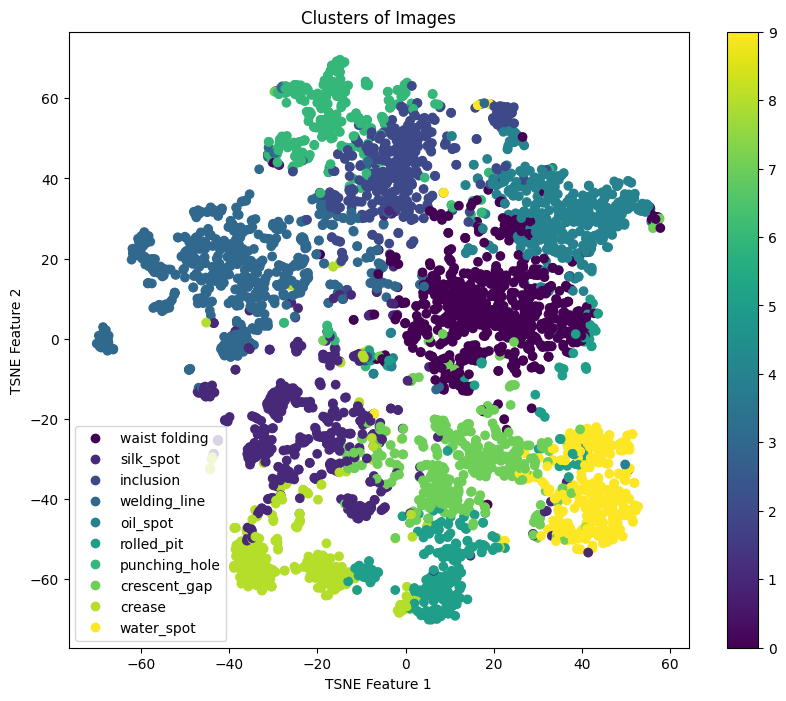

In [2]:
# Import necessary libraries
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gradio as gr

# Check if GPU is available and use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformation for data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),      # Randomly rotate images by 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change image brightness, contrast, etc.
    transforms.Resize((224, 224)),      # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

# Function to load and preprocess images
def load_and_process_images(image_folder, transform, augment_transform):
    processed_images = []
    labels = []
    for label_idx, label_name in enumerate(os.listdir(image_folder)):
        label_folder = os.path.join(image_folder, label_name)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    image_path = os.path.join(label_folder, filename)
                    image = Image.open(image_path).convert('RGB')
                    processed_images.append(transform(image))
                    labels.append(label_idx)
                    # Apply augmentation and add augmented image
                    augmented_image = augment_transform(image)
                    processed_images.append(augmented_image)
                    labels.append(label_idx)
    return torch.stack(processed_images), labels

# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the final fully connected layer
model = model.to(device)
model.eval()

# Function to extract features using ResNet-50
def extract_features(images, model, batch_size=32):
    model.eval()
    features = []
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch_images = images[i:i + batch_size].to(device)
            batch_features = model(batch_images).squeeze().cpu().numpy()
            features.append(batch_features)
    return np.vstack(features)

# Function for K-means clustering
def perform_kmeans(features, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    predicted_labels = kmeans.fit_predict(features)
    return kmeans, predicted_labels

# Specify image folder containing dataset
image_folder = '/content/drive/MyDrive/Colab Notebooks/Datasets/defects_kaggle'

# Load and preprocess images
processed_images, labels = load_and_process_images(image_folder, transform, augment_transform)
processed_images = processed_images.to(device)

# Extract features using ResNet-50
features = extract_features(processed_images, model)

# Perform K-means clustering on extracted features
num_clusters = len(os.listdir(image_folder))  # Number of clusters based on folder names
kmeans, predicted_labels = perform_kmeans(features, num_clusters)

# Reduce dimensionality for visualization
pca = PCA(n_components=50)
pca_features = pca.fit_transform(features)
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_features)

# Plot clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=predicted_labels, cmap='viridis')
plt.title('Clusters of Images')
plt.xlabel('TSNE Feature 1')
plt.ylabel('TSNE Feature 2')
plt.legend(handles=scatter.legend_elements()[0], labels=os.listdir(image_folder))
plt.colorbar(scatter)
plt.show()

# Function to predict the cluster for a new image
def predict_cluster(image):
    image = Image.fromarray(image).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    features = extract_features(image, model)
    cluster = kmeans.predict(features)
    return f"Predicted Cluster: {cluster[0]}"



In [3]:
# Create a mapping from cluster numbers to directory names
cluster_names = {i: name for i, name in enumerate(os.listdir(image_folder))}

In [4]:
def predict_cluster(image):
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        feature = model(image).squeeze().cpu().numpy().reshape(1, -1)
    cluster = kmeans.predict(feature)[0]
    cluster_name = cluster_names[cluster]
    return f"Cluster: {cluster}, Name: {cluster_name}"

gr.Interface(
    fn=predict_cluster,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Image Cluster Prediction",
    description="Upload an image to predict its cluster."
).launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0e5f110c82b3e1f515.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [5]:
from sklearn.metrics import silhouette_score

# Compute the Silhouette Score
silhouette_avg = silhouette_score(features, predicted_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")


Silhouette Score: 0.0996


In [6]:
# Inertia is already computed during KMeans clustering
print(f"Inertia (Within-Cluster Sum of Squares): {kmeans.inertia_:.4f}")

Inertia (Within-Cluster Sum of Squares): 283467.5000


In [7]:
from collections import Counter
import numpy as np

def compute_purity(labels, predicted_labels):
    total = len(labels)
    cluster_labels = np.unique(predicted_labels)
    majority_sum = 0

    for cluster in cluster_labels:
        cluster_indices = np.where(predicted_labels == cluster)
        cluster_true_labels = labels[cluster_indices]
        most_common_label, count = Counter(cluster_true_labels).most_common(1)[0]
        majority_sum += count

    purity = majority_sum / total
    return purity

# Compute Cluster Purity
purity = compute_purity(np.array(labels), predicted_labels)
print(f"Cluster Purity: {purity:.4f}")


Cluster Purity: 0.4364


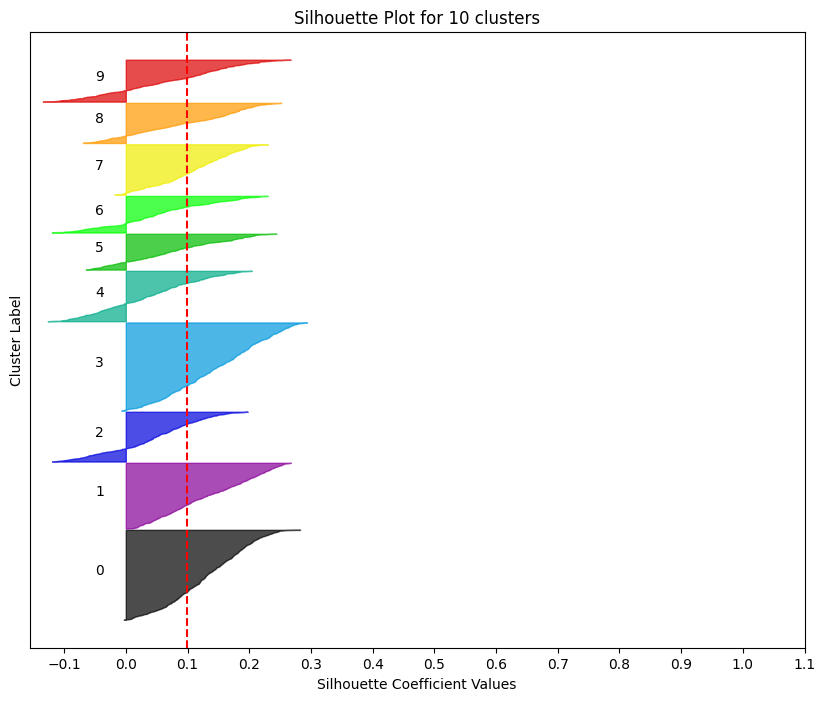

In [8]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples

# Silhouette Plot
def plot_silhouette(features, predicted_labels):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    silhouette_avg = silhouette_score(features, predicted_labels)
    sample_silhouette_values = silhouette_samples(features, predicted_labels)

    y_lower = 10
    for i in range(num_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[predicted_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / num_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_title(f'Silhouette Plot for {num_clusters} clusters')
    ax.set_xlabel('Silhouette Coefficient Values')
    ax.set_ylabel('Cluster Label')
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks(np.arange(-0.1, 1.1, 0.1))
    plt.show()

plot_silhouette(features, predicted_labels)
